In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocaton'),
    ('payments.csv', 'payments'),  # Added payments.csv for specific handling
    ('order_items.csv', 'order_items')
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='110043',
    database='E_commerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'D:/setup/archive'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [23]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import mysql.connector
import numpy as np
db = mysql.connector.connect(host = "localhost",
                             user = "root",
password = "110043",
database = "e_commerce")
cur = db.cursor()


# Basic

# 1. List all unique cities where customers are located. 

In [7]:
query = """ select distinct customer_city from customers """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [26]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp)=2017"""
cur.execute(query)
data = cur.fetchall()
"total order placed in 2017 is ",data[0][0]

('total order placed in 2017 is ', 180404)

<!-- 3. Find the total sales per category. -->

# 3. Find the total sales per category.

In [8]:
query = """ select round(sum(price+freight_value),2) as sales,product_category as category from order_items join products on order_items.product_id = products.product_id group by product_category;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,23059969.14,HEALTH BEAUTY
1,18506503.67,sport leisure
2,11509279.23,Cool Stuff
3,16948358.36,computer accessories
4,20888665.72,Watches present
...,...,...
69,68452.64,Kitchen portable and food coach
70,18729.28,House Comfort 2
71,95976.64,CITTE AND UPHACK FURNITURE
72,5192.16,insurance and services


# 4. Calculate the percentage of orders that were paid in installments.

In [28]:
query = """ SELECT 
    (SUM(CASE
        WHEN payment_installments >= 1 THEN 1
        ELSE 0
    END)) / COUNT(*) * 100 AS installment
FROM
    payments"""
cur.execute(query)
data = cur.fetchall()
data

[(Decimal('99.9981'),)]

# 5. Count the number of customers from each state. 

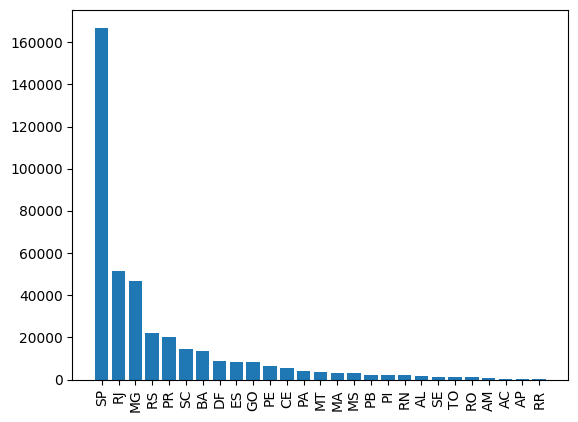

In [29]:
query = """ SELECT 
    COUNT(customer_id), customer_state
FROM
    customers
GROUP BY customer_state """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer_count","state"])
df= df.sort_values(by = "customer_count",ascending = False)
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation = 90)
plt.show()


# Intermediate

# Calculate the number of orders per month in 2018.

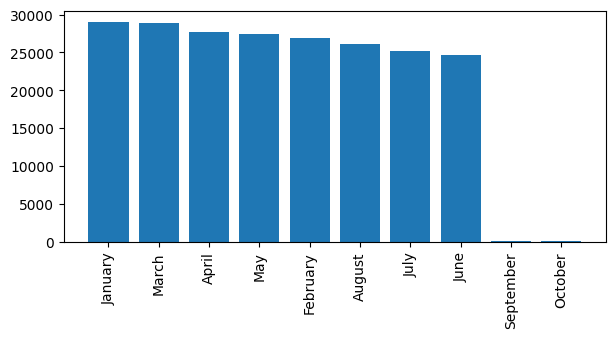

In [30]:
query = """ SELECT 
    COUNT(order_id) as orders,
    MONTHname(order_purchase_timestamp) AS order_month
FROM
    orders
WHERE
    YEAR(order_purchase_timestamp) = 2018
GROUP BY order_month """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["orders","order_month"])
df = df.sort_values(by = "orders",ascending = False )
plt.figure(figsize = (7,3))
plt.bar(df["order_month"],df["orders"],)
plt.xticks(rotation = 90)
plt.show()

# 2. Find the average number of products per order, grouped by customer city.

In [31]:
query = """ with count_per_order as
(select orders.order_id,orders.customer_id ,count(order_items.order_id) as 
order_count from orders join order_items on orders.order_id = order_items.order_id group by orders.order_id,orders.customer_id)
select customers.customer_city,round(avg(count_per_order.order_count),2) as avg_count from customers 
join count_per_order on customers.customer_id = count_per_order.customer_id group by customers.customer_city"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["city","avg"])
df.head(10)

,city,avg
0,treze tilias,15.27
1,indaial,13.38
2,sao jose dos campos,13.66
3,sao paulo,13.87
4,porto alegre,14.10
5,santos,13.94
6,sao francisco do sul,14.82
7,sao vicente,13.09
8,joinville,13.23
9,sao vendelino,12.00


# 3. Calculate the percentage of total revenue contributed by each product category.

In [6]:
query = """ SELECT 
    (SUM(payment_value)) / (COUNT(*) * 100 )AS valuess,
    product_category AS category
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
        JOIN
    payments ON order_items.order_id = payments.order_id
GROUP BY category order by valuess desc """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,12.687343,PCs
1,7.638755,fixed telephony
2,6.567862,HOUSE PASTALS OVEN AND CAFE
3,4.711532,Agro Industria e Comercio
4,4.647890,ELECTRICES 2


# 4. Identify the correlation between product price and the number of times a product has been purchased.

In [33]:
query = """ SELECT 
    products.product_category AS category,
    COUNT(order_items.product_id) AS product,
    ROUND(AVG(order_items.price), 2) AS price
FROM
    order_items
        JOIN
    products ON order_items.product_id = products.product_id
GROUP BY category """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["product","order_count","price"])
df = df.sort_values(by = "price" ,ascending = False)
df.head(10)
arr1 = df["order_count"]
arr2 = df["price"]
np.corrcoef([arr1,arr2])

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

# 5. Calculate the total revenue generated by each seller, and rank them by revenue.

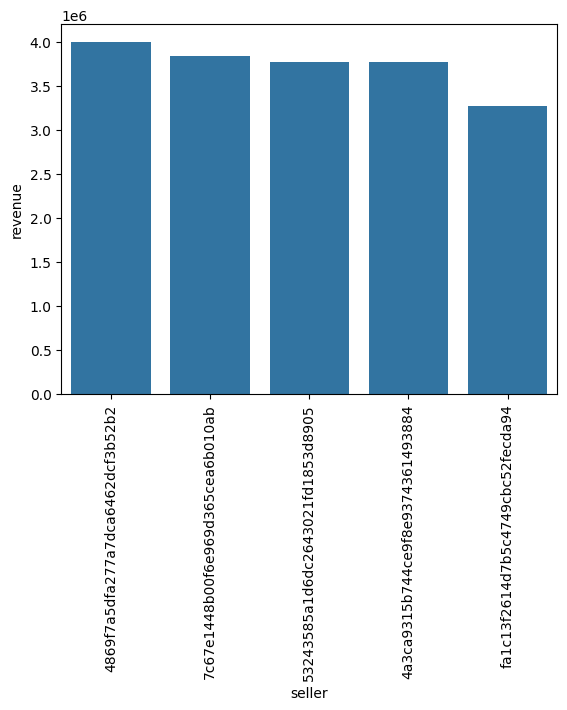

In [5]:
query = """select * ,dense_rank() over(order by revenue desc) as ranks from  
(SELECT 
    ROUND(SUM(order_items.freight_value + order_items.price),
            2) AS revenue,
    sellers.seller_id AS seller
FROM
    order_items
        JOIN
    sellers ON order_items.seller_id = sellers.seller_id
    group by seller ) as a """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["revenue","seller","rank"])
df = df.sort_values(by = "rank" )
df = df.head()
sns.barplot(x = "seller", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

# ADVANCED

# 1. Calculate the moving average of order values for each customer over their order history.

In [4]:
query = """select id , times , payment , avg(payment)over(partition by id order by times rows between 2 preceding and current row) as avrg
from (select orders.customer_id as id , orders.order_purchase_timestamp as times , payments.payment_value as payment from orders
join payments on orders.order_id = payments.order_id)as a  """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["id","times","payments","avrgs"])
df = df.sort_values(by = "payments", ascending = False)
df

,id,times,payments,avrgs
179183,1617b1357756262bfa56ab541c47bc16,2017-09-29 15:24:52,13664.1,13664.080078
179190,1617b1357756262bfa56ab541c47bc16,2017-09-29 15:24:52,13664.1,13664.080078
179184,1617b1357756262bfa56ab541c47bc16,2017-09-29 15:24:52,13664.1,13664.080078
179199,1617b1357756262bfa56ab541c47bc16,2017-09-29 15:24:52,13664.1,13664.080078
179198,1617b1357756262bfa56ab541c47bc16,2017-09-29 15:24:52,13664.1,13664.080078
...,...,...,...,...
1975254,f2def7f64f36952f2f5a9791f0285f34,2018-01-24 23:24:14,0.0,22.636667
207494,197a2a6a77da93f678ea0d379f21da0a,2018-08-28 20:05:14,0.0,0.000000
1975258,f2def7f64f36952f2f5a9791f0285f34,2018-01-24 23:24:14,0.0,22.636667
207495,197a2a6a77da93f678ea0d379f21da0a,2018-08-28 20:05:14,0.0,0.000000


# 2. Calculate the cumulative sales per month for each year.

In [36]:
query = """select 
month , year , round(sum(sales) over(order by sales),2) as sale ,round(sales,2)
 from (select sum(payments.payment_value) as sales 
 , year(orders.order_purchase_timestamp) as year 
 ,monthname(orders.order_purchase_timestamp) as month 
 from payments 
 join orders 
 on orders.order_id = payments.order_id group by year,month ) 
 as sa """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["months","year","sale","sales"])
# df = df.sort_values(by = "payments", ascending = False)
df

,months,year,sale,sales
0,December,2016,2.354400e+02,235.44
1,September,2016,3.262320e+03,3026.88
2,October,2018,1.033836e+04,7076.04
3,September,2018,6.361284e+04,53274.48
4,October,2016,7.726986e+05,709085.76
5,January,2017,2.434555e+06,1661856.48
6,February,2017,5.937451e+06,3502896.11
7,April,2017,1.095091e+07,5013456.35
8,March,2017,1.634927e+07,5398363.19
9,June,2017,2.248459e+07,6135316.56


# 3. Calculate the year-over-year growth rate of total sales.

In [50]:
query = """with a as (select round(sum(payments.payment_value),2) as sales 
 , year(orders.order_purchase_timestamp) as year 
 from payments 
 join orders 
 on orders.order_id = payments.order_id group by year order by year)
 select year, 
 ((round(sales,2)- round(lag(sales) over (order by year),2))/round(lag(sales) over (order by year),2))*100 from a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["year","growth"])
# df = df.sort_values(by = "payments", ascending = False)
df

,year,growth
0,2016,NaN
1,2017,12112.703758
2,2018,20.000924


# Identify the top 3 customers who spent the most money in each year

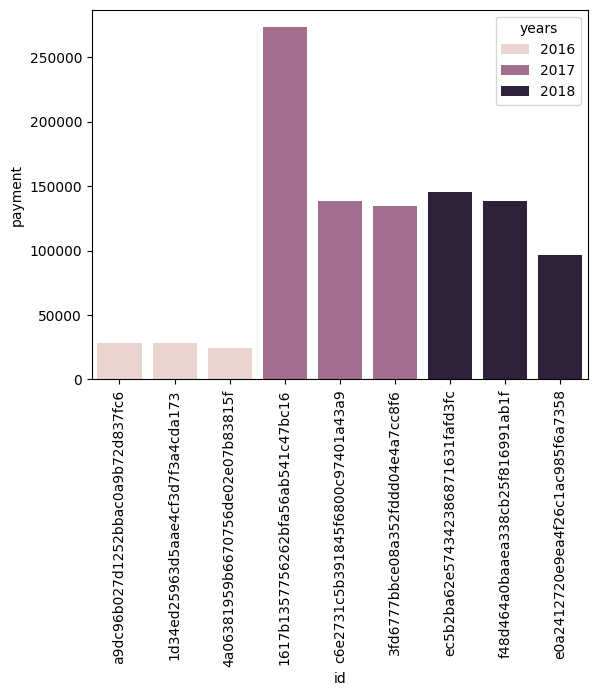

In [3]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()